# Projekt PSI

Zestaw danych zawiera 37 różnych gestów rąk, w tym gesty alfabetu A-Z, gesty liczby 0-9 oraz gest reprezentujący odstęp między literami lub słowami w języku migowym. <br> Każdy gest jest przedstawiony za pomocą obrazów rąk o rozmiarze 50x50 pikseli. <br> W sumie dla każdego gestu dostępnych jest 1500 obrazów, co daje łącznie 55 500 obrazów.

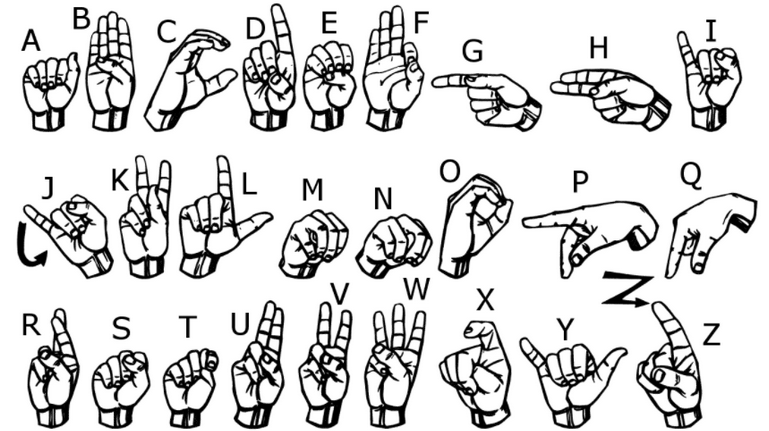

# Import lib

In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

2023-06-26 12:04:36.128234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0
2.12.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

# Data load

In [3]:
data_directory = os.path.join(".", "dataset")
sign_lng_dataset = []
for label in tqdm(sorted(os.listdir(data_directory))):
    label_path = os.path.join(data_directory, label)
    for image in os.listdir(label_path):
        if not image.startswith("augmented_"):
            try:
                image_path = os.path.join(label_path, image)
                img = cv2.resize(cv2.imread(image_path),(50,50))
                sign_lng_dataset.append((img, label))
            except:
                print(image_path)

  0%|                                                    | 0/37 [00:00<?, ?it/s]

./dataset/0/.ipynb_checkpoints


  8%|███▌                                        | 3/37 [00:01<00:12,  2.79it/s]

./dataset/3/.ipynb_checkpoints


 16%|███████▏                                    | 6/37 [00:02<00:11,  2.81it/s]

./dataset/6/.ipynb_checkpoints


100%|███████████████████████████████████████████| 37/37 [00:13<00:00,  2.83it/s]


# EDA data

In [4]:
data_df = pd.DataFrame(sign_lng_dataset, columns=['Image', 'Label'])
data_df.head()

,Image,Label
0,"[[[61, 94, 127], [53, 86, 119], [59, 90, 123],...",0
1,"[[[66, 93, 127], [62, 89, 123], [62, 91, 122],...",0
2,"[[[61, 80, 117], [68, 90, 126], [69, 94, 128],...",0
3,"[[[65, 97, 126], [66, 96, 125], [67, 93, 123],...",0
4,"[[[53, 92, 124], [47, 86, 118], [55, 93, 125],...",0


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   55500 non-null  object
 1   Label   55500 non-null  object
dtypes: object(2)
memory usage: 867.3+ KB


### How much records ?

In [6]:
data_df.shape

(55500, 2)

### How much data in each category ?

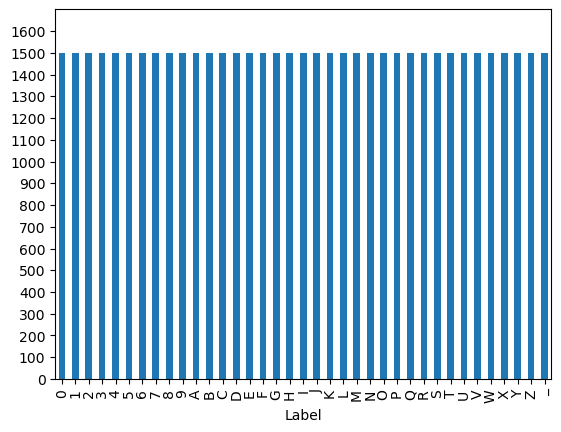

In [7]:
data_df["Label"].value_counts().sort_values(ascending=False).plot(kind="bar")
plt.ylim(0, 1700)
plt.yticks(range(0, 1700, 100))
plt.show()

### How many class ?

In [8]:
data_df["Label"].unique().size

37

In [9]:
data_df["Label"].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_'],
      dtype=object)

### Is any NaN values ?

In [10]:
data_df.isna().any(axis=0)

Image    False
Label    False
dtype: bool

### How image looks like ?

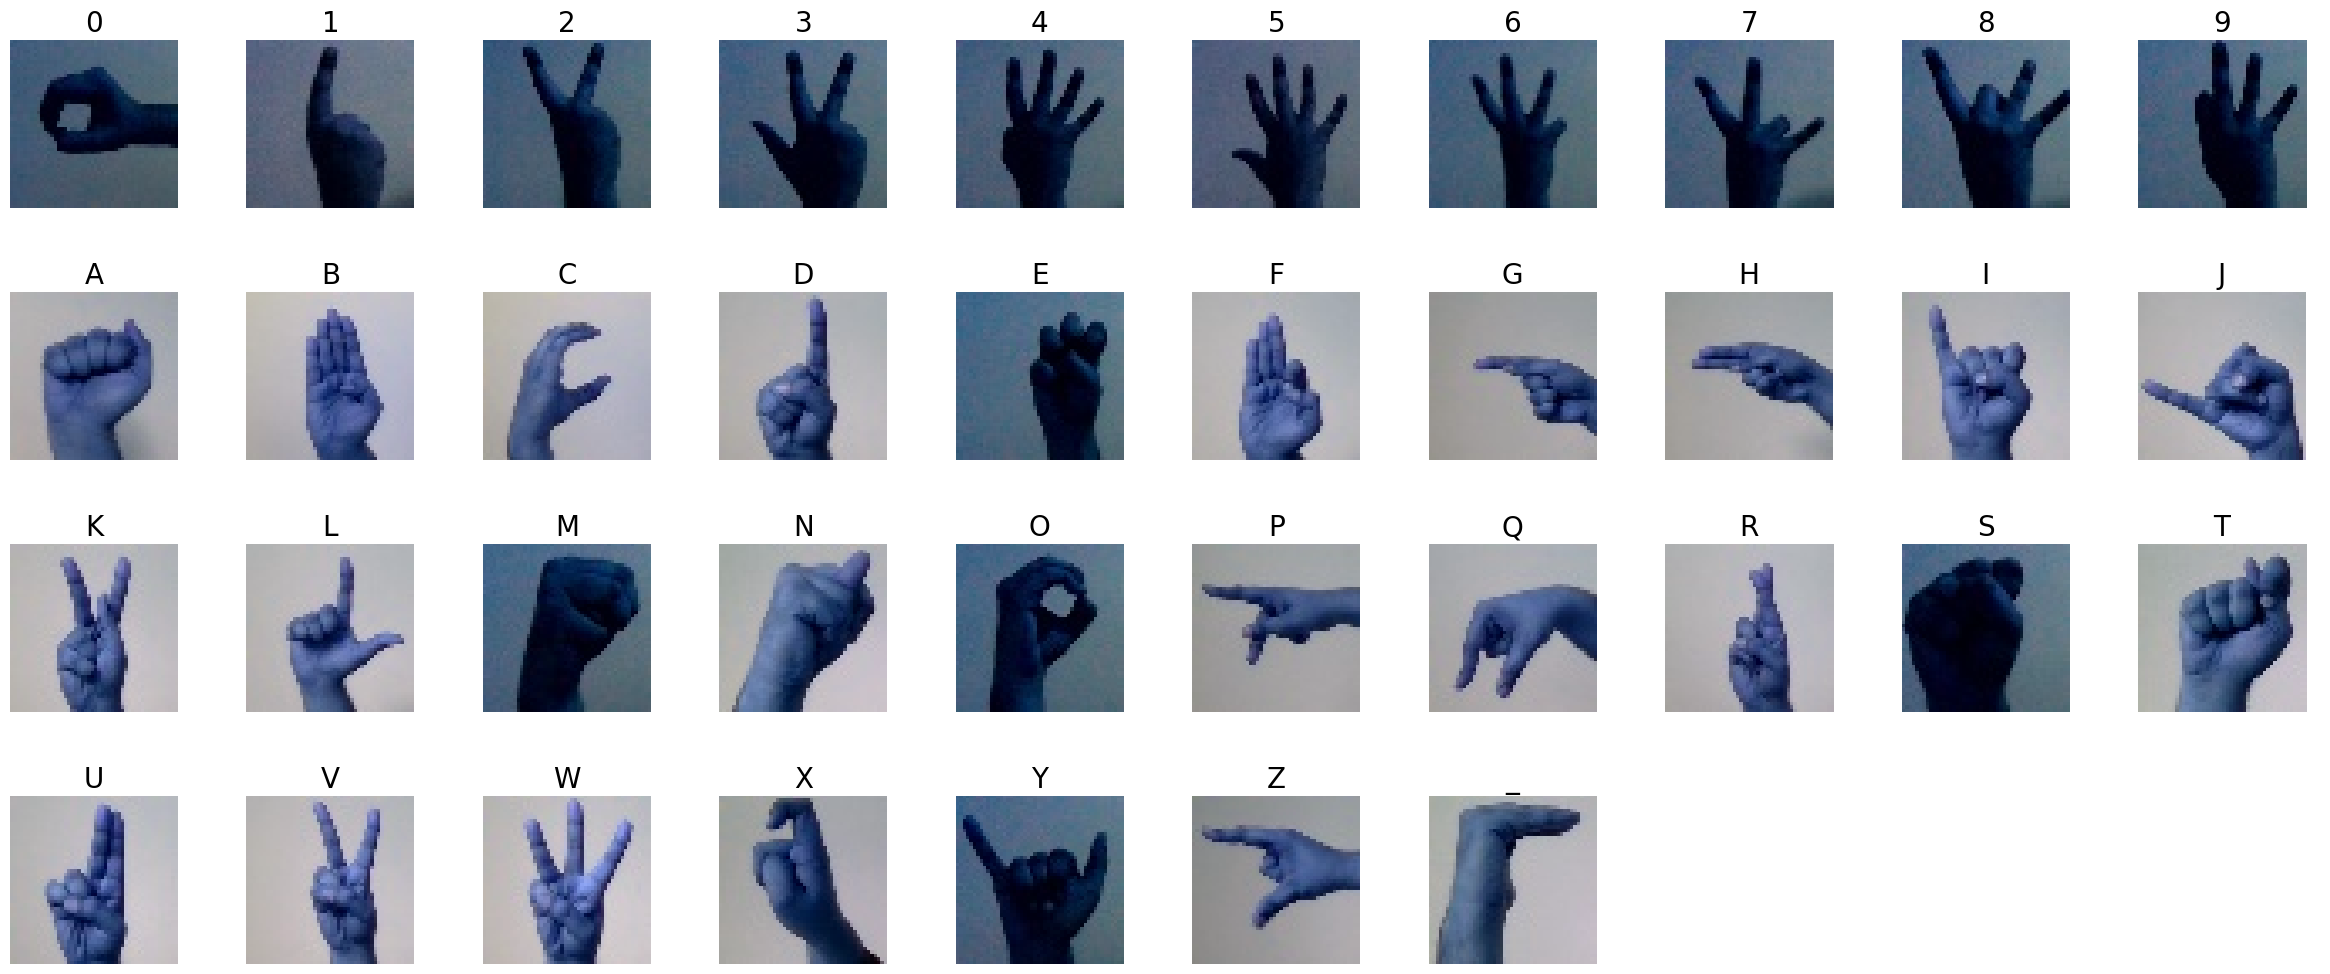

In [11]:
size_of_class = 1500
n_rows = 4
n_cols = 10
fig, axes = plt.subplots(4, 10, figsize=(n_cols * 3, n_rows * 3))

for i, ax in enumerate(axes.flat):
    if i*size_of_class < data_df.shape[0]:
        ax.imshow(sign_lng_dataset[i*size_of_class][0])
        ax.set_title(sign_lng_dataset[i*size_of_class][1], fontsize=20)
    ax.axis('off')
    
fig.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Split data to _Train_, _Validation_ and _Test_ dataset

### Without StratifiedShuffleSplit

In [12]:
X = [element[0] for element in sign_lng_dataset]
y = [element[1] for element in sign_lng_dataset]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

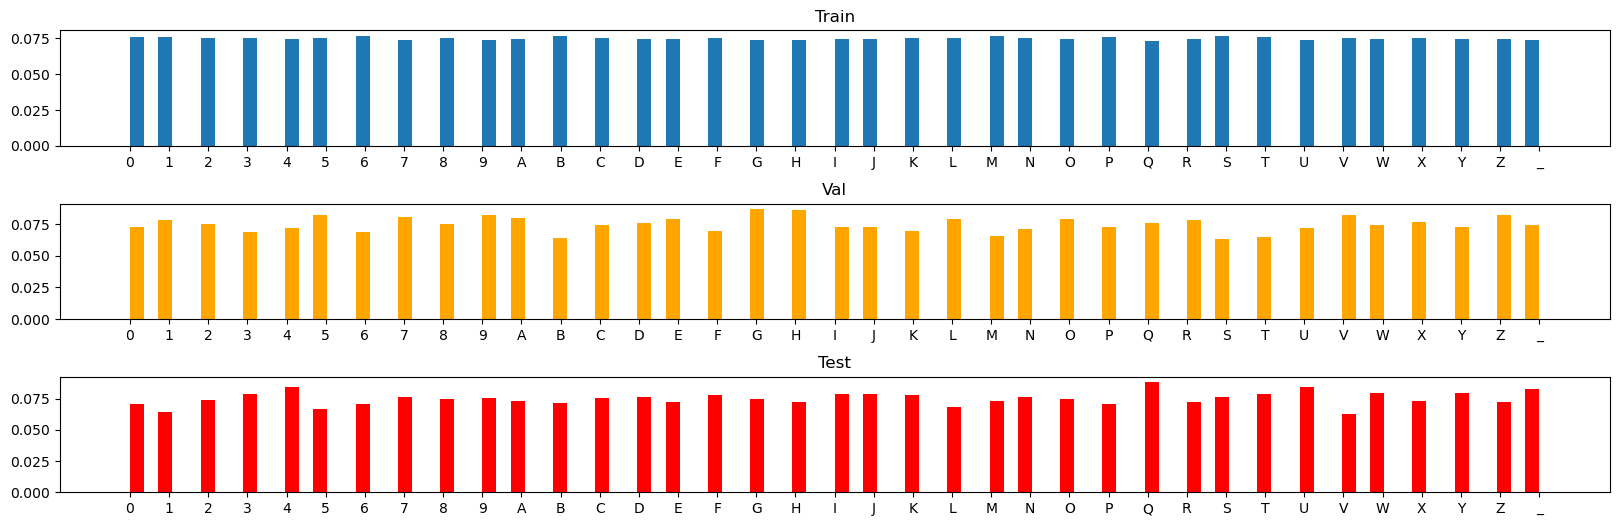

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(20, 6))

axes[0].hist(sorted(y_train), bins=100, density=True)
axes[0].set_title('Train')

axes[1].hist(sorted(y_val), bins=100, density=True, color="orange")
axes[1].set_title('Val')

axes[2].hist(sorted(y_test), bins=100, density=True, color="red")
axes[2].set_title('Test')

plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)

plt.show()

### With StratifiedShuffleSplit

In [15]:
X = [element[0] for element in sign_lng_dataset]
y = [element[1] for element in sign_lng_dataset]

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, val_test_index in sss.split(X, y):
    X_train, X_val_test = [X[i] for i in train_index], [X[i] for i in val_test_index]
    y_train, y_val_test = [y[i] for i in train_index], [y[i] for i in val_test_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)

for val_index, test_index in sss.split(X_val_test, y_val_test):
    X_val, X_test = [X_val_test[i] for i in val_index], [X_val_test[i] for i in test_index]
    y_val, y_test = [y_val_test[i] for i in val_index], [y_val_test[i] for i in test_index]

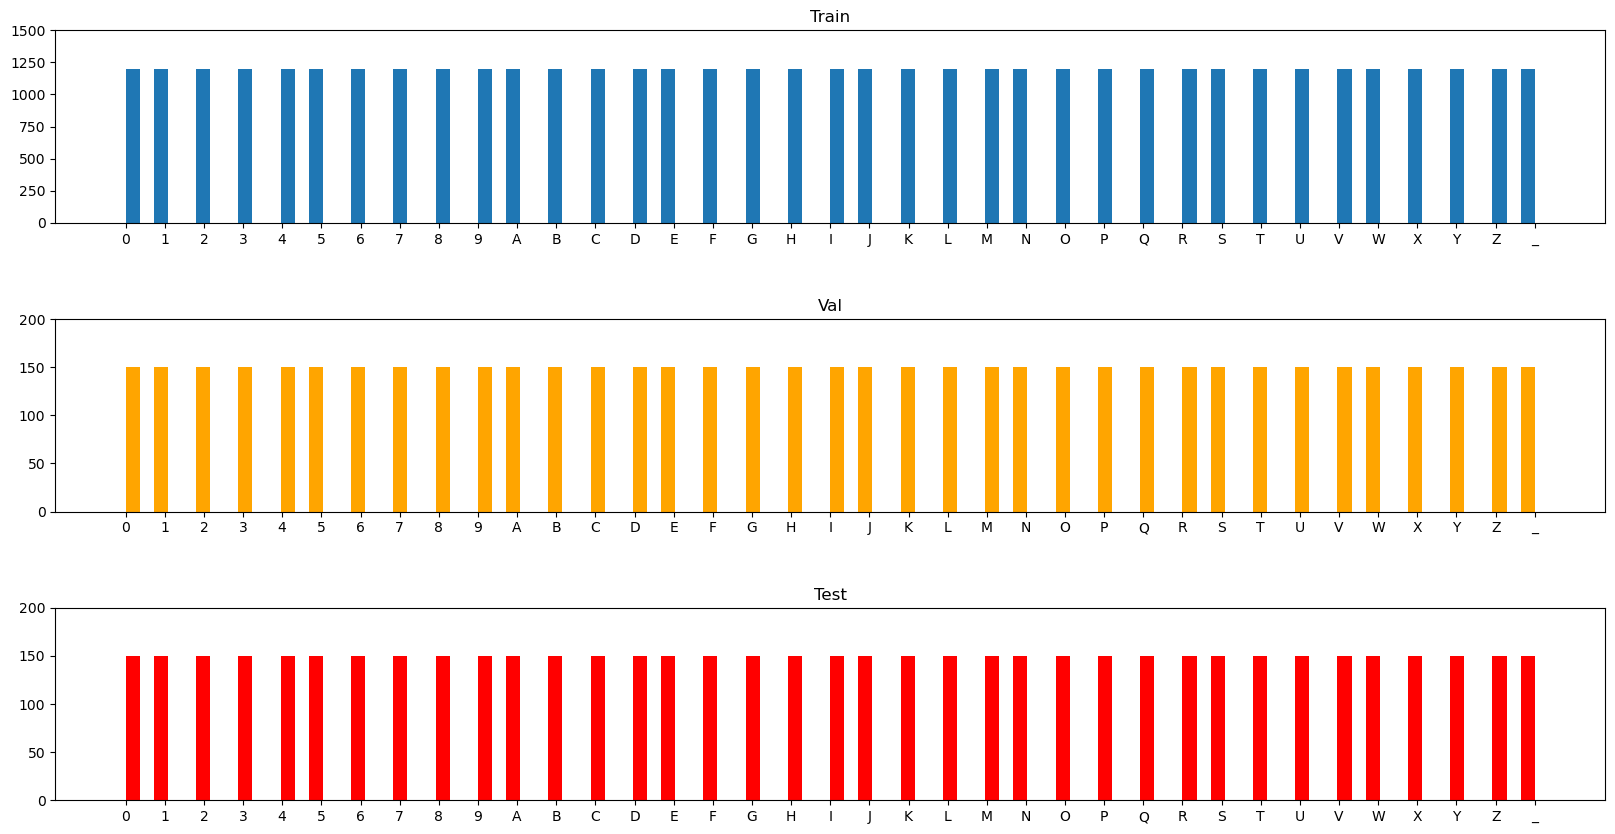

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

axes[0].hist(sorted(y_train), bins=100, density=False)
axes[0].set_title('Train')
axes[0].set_ylim(0, 1500)

axes[1].hist(sorted(y_test), bins=100, density=False, color="orange")
axes[1].set_title('Val')
axes[1].set_ylim(0, 200)

axes[2].hist(sorted(y_test), bins=100, density=False, color="red")
axes[2].set_title('Test')
axes[2].set_ylim(0, 200)

plt.subplots_adjust(wspace=0.5)  
plt.subplots_adjust(hspace=0.5)

plt.show()

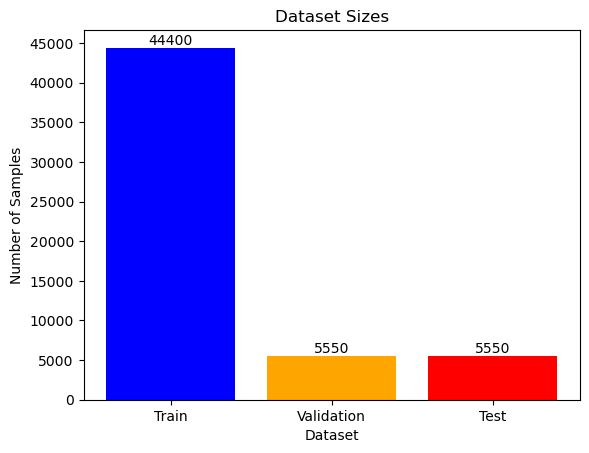

In [18]:
plt.bar(["Train", "Validation", "Test"], [len(y_train), len(y_val), len(y_test)], color=["blue", "orange", "red"])
plt.xlabel("Dataset")
plt.ylabel("Number of Samples")
plt.title("Dataset Sizes")
plt.locator_params(axis='y', nbins=10)

for i, v in enumerate([len(y_train), len(y_val), len(y_test)]):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Label - One hot encoding

In [19]:
label_map = {label: id for id, label in enumerate(data_df["Label"].unique())}
print(label_map)

y_train = np.asarray(to_categorical([label_map[label] for label in y_train]))
y_test = np.asarray(to_categorical([label_map[label] for label in y_test]))
y_val = np.asarray(to_categorical([label_map[label] for label in y_val]))

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, '_': 36}


In [20]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0.], dtype=float32)

# Image normalization

In [21]:
X_train[0].max()

190

In [22]:
X_train = np.asarray(X_train) / 255
X_test = np.asarray(X_test) / 255
X_val = np.asarray(X_val) / 255

In [23]:
X_train[0].max()

0.7450980392156863

# Model

In [24]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation ='relu', input_shape=(50,50,3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(32, (3,3), activation ='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, (3,3), activation ='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(37, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 5184)              0

2023-06-26 12:05:03.514846: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [25]:
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'],)

# Train model

In [26]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
from keras.callbacks import History
from keras.callbacks import TensorBoard 
history = History()

# --- TensorBoard setup
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
# ---

tensorboard_cb = TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5)
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val), callbacks=[tensorboard_cb, early_stopping_cb])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

# Test model

In [ ]:
model.evaluate(X_test, y_test)

# Save model

In [ ]:
model.save(r'/home/jakub/Desktop/Sign-Language-Recognition/first_model_20ep.h5')

# Test model on image outside dataset

In [ ]:
id_map = {id: label for label, id in label_map.items()}  # in order to decode what model predict
print(id_map)

In [ ]:
def sign_language_translator(image_path, model, label=None):
    img = cv2.resize(cv2.imread(image_path),(50,50))
    plt.imshow(img)
    plt.show()
    img = np.asarray(img) / 255
    img = img.reshape((1, 50, 50, 3))
    predict_matrix = model.predict(img)
    predicted_label_id = predict_matrix.argmax()
    predicted_label_name = id_map[predicted_label_id]
    confidence_lvl = predict_matrix[0, predicted_label_id]
    
    print("Model label prediction: ", predicted_label_name)
    print("Confidence: ", round(confidence_lvl * 100, 2), "%")
    if label:
        print("Original label: ", label)

In [ ]:
#sign_language_translator("/home/jakub/Desktop/test2.png", model, "P")

In [ ]:
#sign_language_translator("/home/jakub/Desktop/projekt_AI/dataset/P/1.jpg", model, "P")

In [ ]:
#sign_language_translator("/home/jakub/Desktop/test3.png", model, "0")

In [ ]:
#sign_language_translator("/home/jakub/Desktop/projekt_AI/dataset/0/1.jpg", model, "0")

In [ ]:
#sign_language_translator("/home/jakub/Desktop/projekt_AI/dataset/C/1.jpg", model, "C")

# Model tunning

### Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

datagen = ImageDataGenerator(
        rotation_range = 10,
        shear_range = 0.2,
        zoom_range = [0.5, 1.0],
        horizontal_flip = True,
        brightness_range = [0.2, 1.0])

for root, dirs, files in os.walk("./dataset"):
    for dir in tqdm(dirs):
        for file in os.listdir(os.path.join(root, dir)):
            if file.endswith(".jpg") and not file.startswith("augmented_") and os.path.isfile(os.path.join(root, dir, file)):
                img = load_img(os.path.join(root, dir, file))
                x = img_to_array(img)
                x = x.reshape((1, ) + x.shape)
                datagen.flow(x, batch_size=1, save_to_dir=os.path.join(root, dir), 
                                          save_prefix='augmented_', save_format='jpg'):

In [ ]:
data_directory = os.path.join(".", "dataset")
augmented_dataset = []
for label in tqdm(sorted(os.listdir(data_directory))):
    label_path = os.path.join(data_directory, label)
    for image in os.listdir(label_path):
        if image.startswith("augmented_"):
            image_path = os.path.join(label_path, image)
            img = cv2.resize(cv2.imread(image_path),(50,50))
            augmented_dataset.append((img, label))

In [ ]:
augmented_data_df = pd.DataFrame(augmented_dataset, columns=['Image', 'Label'])
augmented_data_df.head()

In [ ]:
augmented_data_df.shape

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_data_df["Image"][0])
plt.title('Augmented')
plt.axis('off')
plt.show()

In [ ]:
X = [element[0] for element in augmented_dataset]
y = [element[1] for element in augmented_dataset]

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, val_test_index in sss.split(X, y):
    X_train, X_val_test = [X[i] for i in train_index], [X[i] for i in val_test_index]
    y_train, y_val_test = [y[i] for i in train_index], [y[i] for i in val_test_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)

for val_index, test_index in sss.split(X_val_test, y_val_test):
    X_val, X_test = [X_val_test[i] for i in val_index], [X_val_test[i] for i in test_index]
    y_val, y_test = [y_val_test[i] for i in val_index], [y_val_test[i] for i in test_index]

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

axes[0].hist(sorted(y_train), bins=100, density=False)
axes[0].set_title('Train')
axes[0].set_ylim(0, 1500)

axes[1].hist(sorted(y_test), bins=100, density=False, color="orange")
axes[1].set_title('Val')
axes[1].set_ylim(0, 200)

axes[2].hist(sorted(y_test), bins=100, density=False, color="red")
axes[2].set_title('Test')
axes[2].set_ylim(0, 200)

plt.subplots_adjust(wspace=0.5)  
plt.subplots_adjust(hspace=0.5)

plt.show()

In [ ]:
plt.bar(["Train", "Validation", "Test"], [len(y_train), len(y_val), len(y_test)], color=["blue", "orange", "red"])
plt.xlabel("Dataset")
plt.ylabel("Number of Samples")
plt.title("Dataset Sizes")
plt.locator_params(axis='y', nbins=10)

for i, v in enumerate([len(y_train), len(y_val), len(y_test)]):
    plt.text(i, v, str(v), ha='center', va='bottom')

In [ ]:
label_map = {label: id for id, label in enumerate(data_df["Label"].unique())}
print(label_map)

y_train = np.asarray(to_categorical([label_map[label] for label in y_train]))
y_test = np.asarray(to_categorical([label_map[label] for label in y_test]))
y_val = np.asarray(to_categorical([label_map[label] for label in y_val]))

In [ ]:
X_train = np.asarray(X_train) / 255
X_test = np.asarray(X_test) / 255
X_val = np.asarray(X_val) / 255

In [ ]:
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val), callbacks=[tensorboard_cb, early_stopping_cb])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6007

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
#sign_language_translator("/home/jakub/Desktop/test2.png", model, "P")

In [ ]:
#sign_language_translator("/home/jakub/Desktop/projekt_AI/dataset/P/1.jpg", model, "P")

# Save model

In [ ]:
model.save(r'/home/jakub/Desktop/Sign-Language-Recognition/augmented2_model_20ep.h5')

# Other model

In [ ]:
model_2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation ='relu', input_shape=(50,50,3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, (3,3), activation ='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, (3,3), activation ='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.20)
        tf.keras.layers.Dense(37, activation='softmax')
])

model_2.summary()

In [ ]:
history = model2.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val), callbacks=[tensorboard_cb, early_stopping_cb])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6008

In [ ]:
model2.evaluate(X_test, y_test)

In [ ]:
model2.save(r'/home/jakub/Desktop/Sign-Language-Recognition/second_augmented_model_20ep.h5')

# model 3

In [ ]:
model3 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation ='relu', input_shape=(50,50,3)),
        tf.keras.layers.Conv2D(16, (3,3), activation ='relu'),
        tf.keras.layers.Conv2D(16, (3,3), activation ='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Conv2D(32, (3,3), activation ='relu'),
        tf.keras.layers.Conv2D(32, (3,3), activation ='relu'),
        tf.keras.layers.Conv2D(32, (3,3), activation ='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation ='relu'),
        tf.keras.layers.Conv2D(64, (3,3), activation ='relu'),
        tf.keras.layers.Conv2D(64, (3,3), activation ='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(25, activation='softmax')
])

model3.summary()

In [ ]:
history = model3.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val), callbacks=[tensorboard_cb, early_stopping_cb])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6009

In [ ]:
model3.evaluate(X_test, y_test)

In [ ]:
model3.save(r'/home/jakub/Desktop/Sign-Language-Recognition/third_augmented_model_20ep.h5')